In [1]:
import numpy as np
import random
import itertools
import librosa
import librosa.display
import soundfile as sf
import matplotlib.pyplot as plt
import os
import pandas as pd 
import keras.metrics as metrics
from PIL import Image
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers
from keras.layers import Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, Activation, concatenate
from tensorflow.keras.models import Sequential, save_model, load_model, Model
from keras.preprocessing.image import load_img, img_to_array
from keras.callbacks import ModelCheckpoint

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
IMAGE_SIZE = 224
BATCH_SIZE = 32


datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# mfcc

In [4]:
filepath = "/content/drive/MyDrive/EE3063_PROJECT/final/mfcc_model/best_model_mfcc.h5"
new_model = load_model(filepath)

In [5]:
test_1 = datagen.flow_from_directory(
    directory=r"/content/drive/MyDrive/EE3063_PROJECT/final/data/mfcc/test/",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
    seed=42
    )

Found 800 images belonging to 2 classes.


In [6]:
STEP_SIZE_TEST=test_1.n//test_1.batch_size

test_1.reset()

pred1 = new_model.predict_generator(test_1,
steps=STEP_SIZE_TEST,
verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  import sys


25/25 [==============================] - 474s 18s/step


# chroma

In [7]:
filepath = "/content/drive/MyDrive/EE3063_PROJECT/final/chroma_model/best_model_chroma.h5"
new_model = load_model(filepath)

In [8]:
test_2 = datagen.flow_from_directory(
    directory=r"/content/drive/MyDrive/EE3063_PROJECT/final/data/chroma/test/",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
    seed=42
    )

Found 800 images belonging to 2 classes.


In [9]:
STEP_SIZE_TEST=test_2.n//test_2.batch_size

test_2.reset()

pred2 = new_model.predict_generator(test_2,
steps=STEP_SIZE_TEST,
verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  import sys


25/25 [==============================] - 447s 19s/step


# spec

In [10]:
filepath = "/content/drive/MyDrive/EE3063_PROJECT/final/spectogram_model/best_model_spectogram.h5"
new_model = load_model(filepath)

In [11]:
test_3 = datagen.flow_from_directory(
    directory=r"/content/drive/MyDrive/EE3063_PROJECT/final/data/spectogram/test/",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
    seed=42
    )

Found 800 images belonging to 2 classes.


In [12]:
STEP_SIZE_TEST=test_3.n//test_3.batch_size

test_3.reset()

pred3 = new_model.predict_generator(test_3,
steps=STEP_SIZE_TEST,
verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  import sys


25/25 [==============================] - 455s 19s/step


#cf

In [13]:
pred = pred2+pred3+pred1
predicted=np.argmax(pred,axis=1)
y = test_1.labels

TP = 0
TN = 0
FP = 0
FN = 0
for i in range(len(y)):
  if predicted[i] == y[i]:
    if y[i] == 1: 
      TP+=1
    else:
      TN+=1
  else:
    if y[i] == 1: 
      FN+=1
    else:
      FP+=1
print('TP: ', TP)
print('TN: ', TN)
print('FN: ', FN)
print('FP: ', FP)

#precision = TP/(TP+FP)
precision = TP / (TP + FP)

#recall = TP/P
recall = TP / (TP+FN)

f1 = 2 * precision * recall / (precision + recall)

spec = TN /(TN+FP)

print("Precision: %.3f" % precision)
print("Recall: %.3f" % recall)
print("F1-score: %.3f" % f1)
print("Specificity: %.3f" % spec)

TP:  125
TN:  612
FN:  11
FP:  52
Precision: 0.706
Recall: 0.919
F1-score: 0.799
Specificity: 0.922


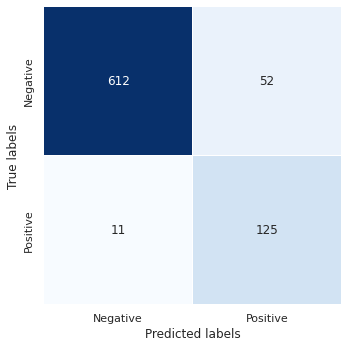

              precision    recall  f1-score   support

    Negative       0.98      0.92      0.95       664
    Positive       0.71      0.92      0.80       136

    accuracy                           0.92       800
   macro avg       0.84      0.92      0.87       800
weighted avg       0.94      0.92      0.93       800



In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

cm = confusion_matrix(y, predicted)
cm_df = pd.DataFrame(cm, index=["Negative", "Positive"], columns=["Negative", "Positive"])

plt.figure(figsize=(5, 5))

sns.set(font_scale=1)

ax = sns.heatmap(cm_df, annot=True, square=True, fmt='d', linewidths=.2, cbar=0, cmap=plt.cm.Blues)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.ylabel("True labels")
plt.xlabel("Predicted labels")
plt.tight_layout()

plt.show()

print(classification_report(y, predicted, target_names=["Negative", "Positive"]))

[0.         0.07831325 1.        ] [0.         0.91911765 1.        ] [2 1 0]


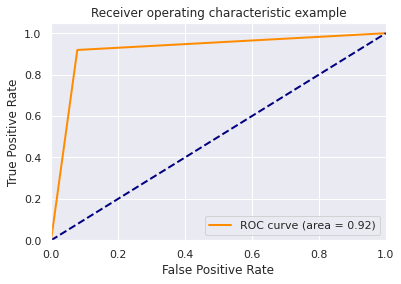

In [16]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle

fpr, tpr, thresholds = roc_curve(y, predicted, pos_label=1)
print(fpr, tpr, thresholds)


plt.figure()
lw = 2
plt.plot(fpr, tpr, color="darkorange",
         lw=lw, label="ROC curve (area = %0.2f)" % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()